# An example of many-to-one (sequence classification)

Original experiment from [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.  
Elements and targets are represented locally (input vectors with only one non-zero bit).  
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.  
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.  
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

## 1. Dataset Exploration

In [1]:
from sequential_tasks import TemporalOrderExp6aSequence

# from jupyterthemes import jtplot - because its installed in the virtual enivro
# jtplot.style()


In [2]:
# Create a data generator.
example_generator = TemporalOrderExp6aSequence.get_predefined_generator(
    # The first argument is the difficulty level of the classification task.
    difficulty_level=TemporalOrderExp6aSequence.DifficultyLevel.EASY,
    # The second argument is the number of sequences generated in each batch of data.
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [3]:
# Decoding the first sequence.
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence.
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## 2. Defining the Model

In [4]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results.
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor.
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        x, _ = self.rnn(x)
        x = self.linear(x)
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## 3. Defining the Training Loop

In [5]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()
    
    # Store the number of sequences that were classified correctly.
    num_correct = 0
    
    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):
        # For each new batch, clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()
        
        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        
        # Perform the forward pass of the model.
        output = model(data)
        
        # We want to keep only those outputs which correspond to the end of a sequence. One approach
        # is to decode the sequences and then store the length of each sequence in a tensor. We can
        # then use this tensor for fancy indexing of the output, after subtracting 1 from it to
        # account for tensor indices starting from 0. The first dimension of the output needs to be
        # indexed using arange for the indexing to correctly pick out each batch. The final output
        # will be of shape (batch_size, output_size).
        data_decoded = train_data_gen.decode_x_batch(data.numpy())
        sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
        output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)
        
        loss = criterion(output, target)
        
        loss.backward()

        optimizer.step()
        
        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).int().sum().item()

    return num_correct, loss.item()

## 4. Defining the Testing Loop

In [6]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()
    
    # Store the number of sequences that were classified correctly.
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
            
            output = model(data)
            data_decoded = test_data_gen.decode_x_batch(data.numpy())
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).int().sum().item()

    return num_correct, loss.item()

## 5. Putting it All Together

In [7]:
import matplotlib.pyplot as plt
from plot_lib import set_default

In [8]:
set_default()

In [9]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Track the value of the loss function and model accuracy across epochs.
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}
    
    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)
        
        # Do the same for the testing loop.
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")
    
    # Generate diagnostic plots for the loss and accuracy.
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 5. Simple RNN: 10 Epochs

[Epoch 1/10] loss: 1.4088, acc: 24.29% - test_loss: 1.3520, test_acc: 27.12%
[Epoch 2/10] loss: 1.3632, acc: 24.50% - test_loss: 1.3637, test_acc: 28.53%
[Epoch 3/10] loss: 1.3268, acc: 32.56% - test_loss: 1.3403, test_acc: 34.58%
[Epoch 4/10] loss: 1.3203, acc: 35.18% - test_loss: 1.2760, test_acc: 37.30%
[Epoch 5/10] loss: 1.1956, acc: 38.71% - test_loss: 1.3106, test_acc: 38.71%
[Epoch 6/10] loss: 1.2359, acc: 45.16% - test_loss: 1.1596, test_acc: 44.66%
[Epoch 7/10] loss: 1.1036, acc: 45.36% - test_loss: 1.2020, test_acc: 44.35%
[Epoch 8/10] loss: 0.9191, acc: 47.68% - test_loss: 1.1514, test_acc: 46.57%
[Epoch 9/10] loss: 1.0743, acc: 46.37% - test_loss: 0.9353, test_acc: 47.68%
[Epoch 10/10] loss: 0.9168, acc: 53.43% - test_loss: 0.9043, test_acc: 60.58%


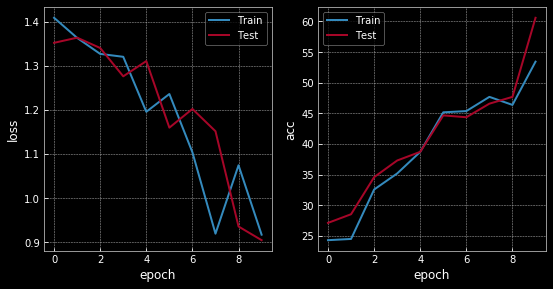

In [10]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [11]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


## 5. Simple LSTM: 10 Epochs

[Epoch 1/10] loss: 1.3186, acc: 26.61% - test_loss: 1.4506, test_acc: 25.50%
[Epoch 2/10] loss: 1.4103, acc: 28.02% - test_loss: 1.4119, test_acc: 26.81%
[Epoch 3/10] loss: 1.3737, acc: 30.95% - test_loss: 1.3921, test_acc: 35.28%
[Epoch 4/10] loss: 1.3383, acc: 35.99% - test_loss: 1.3520, test_acc: 38.00%
[Epoch 5/10] loss: 1.3757, acc: 38.61% - test_loss: 1.3662, test_acc: 36.69%
[Epoch 6/10] loss: 1.3418, acc: 37.10% - test_loss: 1.3436, test_acc: 38.41%
[Epoch 7/10] loss: 1.3079, acc: 41.33% - test_loss: 1.2759, test_acc: 46.67%
[Epoch 8/10] loss: 1.3017, acc: 44.25% - test_loss: 1.2421, test_acc: 46.67%
[Epoch 9/10] loss: 1.2173, acc: 52.22% - test_loss: 1.1768, test_acc: 55.95%
[Epoch 10/10] loss: 1.1625, acc: 65.93% - test_loss: 1.1374, test_acc: 79.33%


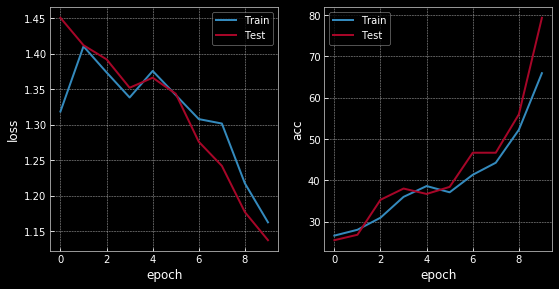

In [12]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [13]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


## 6. RNN: Increasing Epoch to 100

[Epoch 100/100] loss: 0.2004, acc: 89.21% - test_loss: 0.3122, test_acc: 87.30%


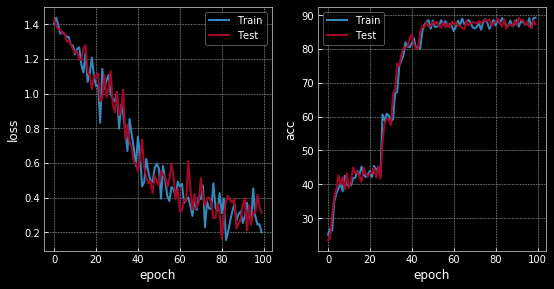

In [14]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## LSTM: Increasing Epoch to 100

[Epoch 100/100] loss: 0.1337, acc: 89.52% - test_loss: 0.2464, test_acc: 87.50%


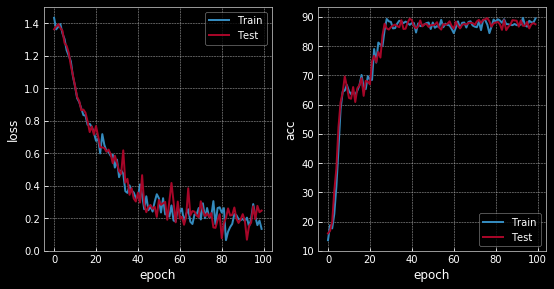

In [15]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## 7. Model Evaluation

In [16]:
import collections
import random


def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels.
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator.
    data_generator = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears.
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.numpy())
            target_decoded = data_generator.decode_y_batch(target.numpy())

            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))
    
    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100 
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class.
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')
    
    # Report some random sequences for examination.
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)] 
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation.
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [17]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 88.91%.

Q: 258 / 258 correct
R: 198 / 249 correct
S: 232 / 232 correct
U: 194 / 253 correct

Here are some example sequences:
BYdcaYbE -> U was labelled U
BdYcbXE -> S was labelled S
BYbdYabE -> U was labelled U
BcYacYbE -> U was labelled U
BYbdYabE -> U was labelled U
BYbdYabE -> U was labelled U
BYdcaYbE -> U was labelled U
BYbdYabE -> U was labelled U
BdYcbXE -> S was labelled S
BYbdYabE -> U was labelled U

There were no misclassified sequences.
